# Прогнозирование оттока клиентов в телекоме

## ОГЛАВЛЕНИЕ

[Описание проекта](#description)

[Цель проекта](#purpose)

[1. Изучение общей информации](#1)

- [1.1 Вывод по анализу общей информации](#1.1)

[2. Предобработка данных](#2)

- [2.1 Объединение таблиц и заполнение пропусков](#2.1)

- [2.2 Добавление новых столбцов](#2.2)
    
- [2.3 Вывод по предобработке данных](#2.3)

[3. Анализ данных](#3)

- [3.1 Корреляция признаков](#3.1)

- [3.2 Анализ использования сервисов клиентами](#3.2)

- [3.3 Анализ "портрета пользователя"](#3.3)

- [3.4 Анализ денежных потоков](#3.4)

- [3.5 Вывод по исследовательскому анализу](#3.5)

[4. Подготовка данных](#4)

- [4.1 Удаление лишнего](#4.1)

- [4.2 Кодирование категориальных признаков](#4.2)

- [4.3 Разбиение на выборки](#4.3)

[5. Обучение моделей](#5)

- [5.1 Константная модель](#5.1)

- [5.2 Решающее дерево](#5.2)

- [5.3 Случайный лес](#5.3)

- [5.4 Логистическая регрессия](#5.4)

- [5.5 CatBoost](#5.5)

- [5.6 LGBMClassifier](#5.6)

[6. Анализ моделей](#6)

- [5.1 Тестирование лучших](#6.1)

- [5.2 Сравнение моделей и выбор лучших](#6.2)

[Общий вывод](#7)


<a id='description'></a>
## Описание проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

<a id='purpose'></a>
## Цель проекта

Построить прототип модели машинного обучения для прогнозирования оттока клиентов оператора связи. Клиентам, которые близки к уходу, будут предлагаться специальные условия обслуживания и промокоды.  

Необходимо обучить модель, у которой метрика качества AUC-ROC будет выше, чем 0.88

<a id='1'></a>
## Изучение общей информации

In [1]:
#Импортируем нужные библиотеки
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from catboost import Pool

from lightgbm import LGBMClassifier
import lightgbm as lgb


#Включаем полное отображение всех колонок таблиц
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Прочитаем датасеты
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
#Заведем словарь с именами датасетов для дальнейшего использования в функциях
data = [contract, personal, internet, phone]
data_names = ['contract', 'personal', 'internet', 'phone']

In [4]:
#Выведем первые 5 строк таблиц для знакомства с данными
for dataset in data:
    display(dataset.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**В таблице contract** видим данные о: дате начала и завершения контракта, типе договора (помесячный или годовой), наличии безбумажного счета, методе платежа, ежемесячной сумме платежей, общей сумму платежей.  

**В таблице personal** видим данные о: поле клиента, пенсионном возрасте, наличии партнера и иждивенцев.  

**В таблице internet** видим данные о следующих услугах: вид подключения к интернету, онлайн-безопасность, резервное копирование, антивирус, техподдержка, стриминговое ТВ и каталог фильмов.  

**В таблице phone** видим данные о: многоканальном подключении.

In [5]:
#Выведем сводную информацию о данных во всех датасетах
for idx, dataset in enumerate(data):
    print('---------------///////////---------------')
    print(f'Сводная информация о датасете: {data_names[idx]}') 
    print(f'Количество полных дубликатов: {dataset.duplicated().sum()}')
    print(f'Размер датасета: {dataset.shape}')
    dataset.info()
    print()
    print(f'Количество пропущенных значений в датасете: {data_names[idx]}')
    missed = dataset.isna().sum().to_frame()
    missed = missed.rename(columns = {0: 'missing_values'})
    missed['% of total'] = ((missed['missing_values'] / dataset.shape[0])*100).round(2)
    display(missed.sort_values(by = 'missing_values', ascending = False))
    print()

---------------///////////---------------
Сводная информация о датасете: contract
Количество полных дубликатов: 0
Размер датасета: (7043, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Количество пропущенных значений в датасете: contract


,missing_values,% of total
customerID,0,0.0
BeginDate,0,0.0
EndDate,0,0.0
Type,0,0.0
PaperlessBilling,0,0.0
PaymentMethod,0,0.0
MonthlyCharges,0,0.0
TotalCharges,0,0.0



---------------///////////---------------
Сводная информация о датасете: personal
Количество полных дубликатов: 0
Размер датасета: (7043, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Количество пропущенных значений в датасете: personal


,missing_values,% of total
customerID,0,0.0
gender,0,0.0
SeniorCitizen,0,0.0
Partner,0,0.0
Dependents,0,0.0



---------------///////////---------------
Сводная информация о датасете: internet
Количество полных дубликатов: 0
Размер датасета: (5517, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB

Количество пропущенных значений в датасете: internet


,missing_values,% of total
customerID,0,0.0
InternetService,0,0.0
OnlineSecurity,0,0.0
OnlineBackup,0,0.0
DeviceProtection,0,0.0
TechSupport,0,0.0
StreamingTV,0,0.0
StreamingMovies,0,0.0



---------------///////////---------------
Сводная информация о датасете: phone
Количество полных дубликатов: 0
Размер датасета: (6361, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB

Количество пропущенных значений в датасете: phone


,missing_values,% of total
customerID,0,0.0
MultipleLines,0,0.0


<a id='1.1'></a>
### Выводы по анализу общей информации

1. Перед нами 4 датасета с информацией о клиентах оператора связи. В датасетах contract и personal одинаковое количество строк, в двух остальных сетах оно меньше, это означает, что часть клиентов пользуется только какой-то одной из услуг (интернет или телефония)
2. Ни в одной из таблиц нет ни пропусков, ни полных дубликатов
3. Некорректный формат данных выявлен в таблице contract в колонках BeginDate и EndDate, а также у TotalCharges
4. У булевых признаков разный формат (везде yes/no, кроме колонки SeniorCitizen в датасете personal (там 1/0). Желательно перевести в числа, большинство моделей с ними лучше справляются
5. Напрашивается объединение таблиц в одну - есть общий признак customerID
6. Данные о датах начала и конца обслуживания стоит перевести в месяцы и добавить эту информацию отдельной колонкой. Столбцы с датами будут малополезны при обучении, а продолжительность обслуживания более информативна для анализа
7. После объединения датасетов можно сделать новую колонку с данными об объеме использования сервисов каждым клиентом: только телефония, только интернет и оба сразу
8. Необходимо добавить колонку со статусом клиента ушел/не ушел (на основании колонки EndDate), это будет целевой признак при обучении

<a id='2'></a>
## Предобработка данных

<a id='2.1'></a>
### Объединение таблиц и заполнение пропусков

In [6]:
#Объединяем данные в один датасет
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [7]:
#Посмотрим, где появились пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       6361 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


In [8]:
#Заполним образовавшиеся пропуски
for i in ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    data[i] = data[i].fillna('No')

In [9]:
#Посмотрим, что за пробелы в колонке TotalCharges
data.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,No,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,Yes,No,No,No,No,No,No,No
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,Yes,No,No,No,No,No,No,No
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


Судя по срезу, пропуски в колонке TotalCharges - это клиенты со сроком обслуживания меньше месяца, соответственно, для них итоговая сумма за услуги должна равняться потраченному за месяц. Заполним пропуски на основе колонки MonthlyCharges

In [10]:
#Заполним пропуски в колонке TotalCharges
data.loc[data['TotalCharges'] == ' ', 'TotalCharges'] = data['MonthlyCharges']
data['TotalCharges'] = data['TotalCharges'].astype('float')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
dtypes: float64(2), int64(1), object(17)
memory usage: 1.4+ MB


<a id='2.2'></a>
### Добавление новых столбцов и изменение типов данных

In [12]:
#Добавим будущий целевой признак Leave со значениями 1 (клиент ушел) и 0 (остается клиентом)
data['Leave'] = 1
data.loc[data['EndDate'] == 'No', 'Leave'] = 0

In [13]:
#Добавим колонку InternetUser со значениями 1/0, заполним на основе пропусков Nan из InternetService
data['InternetUser'] = 1
data.loc[data['InternetService'] == 'No', 'InternetUser'] = 0

In [14]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Leave,InternetUser
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No,0,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,0,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,1,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No,0,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,1,1


In [15]:
#Введем вместо No в столбце EndDate дату, на которую актуален датасет. 
#Это понадобится для подсчета количества времени, которое клиенты оставались в компании
data['EndDate']= data['EndDate'].replace('No', '2020-02-01')

In [16]:
#Заменим формат в колонках с датами, также уберем часы-минуты
data['BeginDate']= pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['EndDate']= pd.to_datetime(data['EndDate'], format='%Y-%m-%d',errors='coerce')

In [17]:
#Рассчитаем количество месяцев, которое клиенты пробыли с компанией, для этого добавим временные колонки
data['BeginYear'] = pd.DatetimeIndex(data['BeginDate']).year
data['EndYear'] = pd.DatetimeIndex(data['EndDate']).year
data['BeginMonth'] = pd.DatetimeIndex(data['BeginDate']).month
data['EndMonth'] = pd.DatetimeIndex(data['EndDate']).month

#Добавляем в виде новой колонки
data['Months'] = ((data['EndYear'] - data['BeginYear']) * 12 + (data['EndMonth'] - data['BeginMonth']))

#Промежуточные столбцы удаляем
data = data.drop(['BeginYear','EndYear','BeginMonth','EndMonth'], axis=1)

In [18]:
#Переведем соответствующие колонки в формат 1/0
for i in ['PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    data[i] = data[i].replace('No', 0)
    data[i] = data[i].replace('Yes', 1)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
MultipleLines       7043 non-null int64
InternetService     7043 non-null object
OnlineSecurity      7043 non-null int64
OnlineBackup        7043 non-null int64
DeviceProtection    7043 non-null int64
TechSupport         7043 non-null int64
StreamingTV         7043 non-null int64
StreamingMovies     7043 non-null int64
Leave               7043 non-null int64
InternetUser        7043 n

In [20]:
#Выведем уникальные значения в небулевых столбцах
for i in ['BeginDate', 'EndDate', 'Type', 'PaymentMethod', 'MonthlyCharges', 'gender', 'InternetService', 'Months']:
    print('Уникальные значения столбца', i)
    print(data[i].unique())

Уникальные значения столбца BeginDate
['2020-01-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2019-10-01T00:00:00.000000000' '2016-05-01T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-03-01T00:00:00.000000000'
 '2018-04-01T00:00:00.000000000' '2019-04-01T00:00:00.000000000'
 '2017-07-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2019-01-01T00:00:00.000000000' '2018-10-01T00:00:00.000000000'
 '2015-04-01T00:00:00.000000000' '2015-09-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2014-05-01T00:00:00.000000000'
 '2015-10-01T00:00:00.000000000' '2014-03-01T00:00:00.000000000'
 '2018-05-01T00:00:00.000000000' '2019-11-01T00:00:00.000000000'
 '2019-02-01T00:00:00.000000000' '2016-01-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2014-02-01T00:00:00.000000000' '2018-06-01T00:00:00.000000000'
 '2019-12-01T00:00:00.000000000' '2017-11-01T00:00:00.000000000'
 '2019-06-01T00:00:00.000000000' '2016-04-01T00:00:0

In [21]:
#Удалим колонки с датами как малопригодные для обучения моделей (ценные для нас данные уже перенесены в Months)
data = data.drop(['BeginDate','EndDate'], axis=1)

In [22]:
data

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Leave,InternetUser,Months
0,7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,0,DSL,0,1,0,0,0,0,0,1,1
1,5575-GNVDE,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,0,DSL,1,0,1,0,0,0,0,1,34
2,3668-QPYBK,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,0,DSL,1,1,0,0,0,0,1,1,2
3,7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,0,DSL,1,0,1,1,0,0,0,1,45
4,9237-HQITU,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,0,Fiber optic,0,0,0,0,0,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,1,Mailed check,84.80,1990.50,Male,0,1,1,1,DSL,1,0,1,1,1,1,0,1,24
7039,2234-XADUH,One year,1,Credit card (automatic),103.20,7362.90,Female,0,1,1,1,Fiber optic,0,1,1,0,1,1,0,1,72
7040,4801-JZAZL,Month-to-month,1,Electronic check,29.60,346.45,Female,0,1,1,0,DSL,1,0,0,0,0,0,0,1,11
7041,8361-LTMKD,Month-to-month,1,Mailed check,74.40,306.60,Male,1,1,0,1,Fiber optic,0,0,0,0,0,0,1,1,4


<a id='2.3'></a>
### Вывод по предобработке данных

Имеющиеся 4 сета с данными были объединены в один датафрейм. Некорректные типы данных заменены, пропуски заполнены. Также в таблицу добавлены три дополнительные колонки: Leave (ушел клиент или нет), Month (срок работы клиента с компанией) и InternetUser (является ли пользователем интернета или только мобильной связи). Первый признак будет целевым, второй более эффективно заменит удаленные колонки с датами. Третий будет полезен для визуализации в процессе анализа данных.

<a id='3'></a>
## Анализ данных

<a id='3.1'></a>
### Корреляция признаков

In [23]:
#Посмотрим корреляцию признаков
display(data.corr())

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Leave,InternetUser,Months
PaperlessBilling,1.000000,0.352150,0.158562,0.156530,-0.014877,-0.111377,0.163530,-0.003636,0.126735,0.103797,0.037880,0.223841,0.211716,0.191825,0.321013,0.006152
MonthlyCharges,0.352150,1.000000,0.651182,0.220173,0.096848,-0.113890,0.490434,0.296594,0.441780,0.482692,0.338304,0.629603,0.627429,0.193356,0.763557,0.247900
TotalCharges,0.158562,0.651182,1.000000,0.102997,0.317532,0.062124,0.468516,0.411679,0.509256,0.522012,0.431910,0.514999,0.520124,-0.198347,0.375229,0.826164
SeniorCitizen,0.156530,0.220173,0.102997,1.000000,0.016479,-0.211185,0.142948,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,0.150889,0.182742,0.016567
Partner,-0.014877,0.096848,0.317532,0.016479,1.000000,0.452676,0.142057,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,-0.150448,-0.000615,0.379697
Dependents,-0.111377,-0.113890,0.062124,-0.211185,0.452676,1.000000,-0.024526,0.080972,0.023671,0.013963,0.063268,-0.016558,-0.039741,-0.164221,-0.139812,0.159712
MultipleLines,0.163530,0.490434,0.468516,0.142948,0.142057,-0.024526,1.000000,0.098108,0.202237,0.201137,0.100571,0.257152,0.258751,0.040102,0.210564,0.331941
OnlineSecurity,-0.003636,0.296594,0.411679,-0.038653,0.143106,0.080972,0.098108,1.000000,0.283832,0.275438,0.354931,0.176207,0.187398,-0.171226,0.333403,0.327203
OnlineBackup,0.126735,0.441780,0.509256,0.066572,0.141498,0.023671,0.202237,0.283832,1.000000,0.303546,0.294233,0.282106,0.274501,-0.082255,0.381593,0.360277
DeviceProtection,0.103797,0.482692,0.522012,0.059428,0.153786,0.013963,0.201137,0.275438,0.303546,1.000000,0.333313,0.390874,0.402111,-0.066160,0.380754,0.360653


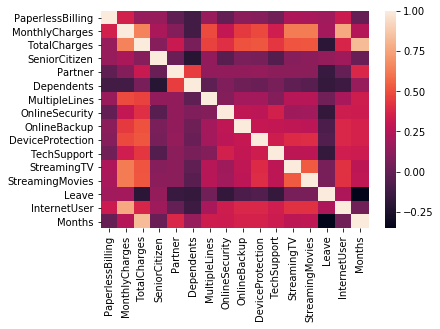

<Figure size 1440x864 with 0 Axes>

In [23]:
#Визуализируем корреляцию
sns.heatmap(data.corr())
plt.figure(figsize=(20,12))
plt.show()

**Вывод.**  Анализ корреляции показывает, что самая сильная взаимосвязь существует между признаками MonthlyCharges и TotalCharges (что логично, т.к. общая сумма затрат прямо зависит от ежемесячных).

<a id='3.2'></a>
### Анализ использования сервисов клиентами

Рассмотрим, какие виды сервисов используют клиенты компании, в том числе ушедшие.

In [24]:
#Создадим функцию для круговой диаграммы, показывающей доли клиентов, использующих те или иные сервисы
def round(column, label1, label2, title):
    labels = [label1, label2]
    sizes = column.value_counts().values
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=120)
    ax1.axis('equal')  
    plt.tight_layout()
    plt.title(title, fontsize=18)
    plt.show()

In [25]:
#Сохраним срез данных с ушедшими клиентами в отдельный датасет, он пригодится для анализа
data_leave = data.query('Leave == 1')

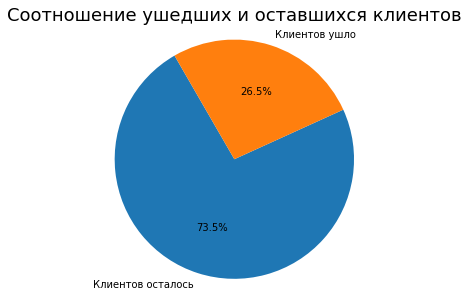

In [26]:
#Выведем диаграмму с долей ушедших клиентов
round(data['Leave'], 'Клиентов осталось', 'Клиентов ушло', 'Соотношение ушедших и оставшихся клиентов')

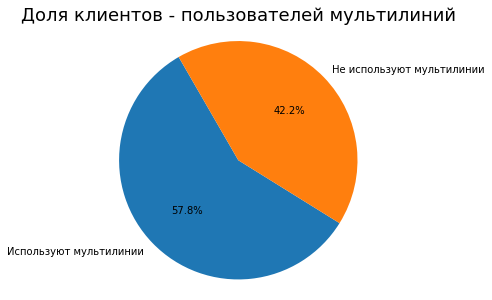

In [27]:
#Выведем диаграмму по клиентам, использующим и не использующим мультилинии
round(data['MultipleLines'], 'Используют мультилинии', 'Не используют мультилинии', 'Доля клиентов - пользователей мультилиний')

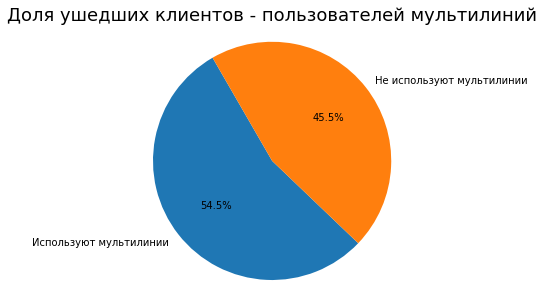

In [28]:
#Выведем диаграмму по пользоваталям мультилиний - какой процент ушедших пользуется мультилиями, а какой - нет
round(data_leave['MultipleLines'], 'Используют мультилинии', 'Не используют мультилинии', 'Доля ушедших клиентов - пользователей мультилиний')


Видим, что клиентов, которые используют мультилинии против тех, кто не использует: 58:42%. Это соотношение для ушедших клиентов сохраняется практически то же самое. То есть, сервис мультилиний не оказывает значительного влияния на уход клиента от компаний.

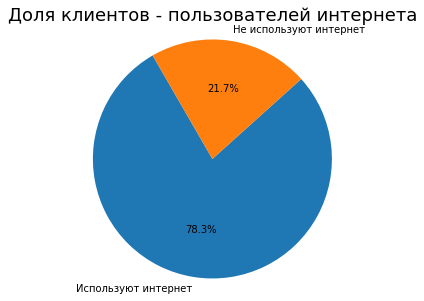

In [29]:
#Выведем диаграмму по клиентам, использующим и не использующим интернет
round(data['InternetUser'], 'Используют интернет', 'Не используют интернет', 'Доля клиентов - пользователей интернета')

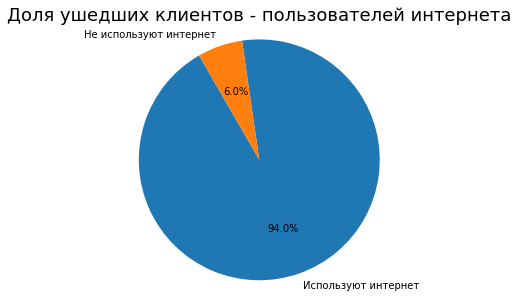

In [30]:
#Выведем диаграмму по ушедшим клиентам, использующим и не использующим интернет
round(data_leave['InternetUser'], 'Используют интернет', 'Не используют интернет', 'Доля ушедших клиентов - пользователей интернета')

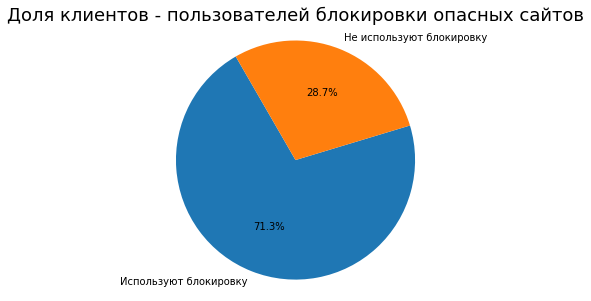

In [31]:
#Выведем диаграмму по клиентам, использующим и не использующим блокировку опасных сайтов
round(data['OnlineSecurity'], 'Используют блокировку', 'Не используют блокировку', 'Доля клиентов - пользователей блокировки опасных сайтов')

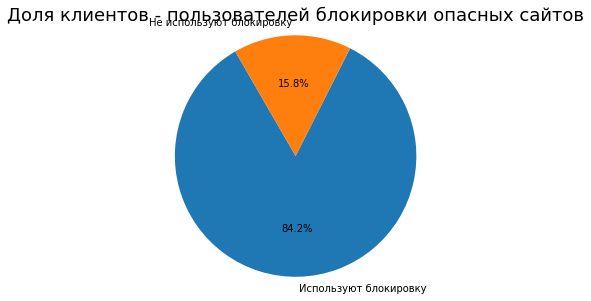

In [32]:
#Выведем диаграмму по клиентам, использующим и не использующим блокировку опасных сайтов
round(data_leave['OnlineSecurity'], 'Используют блокировку', 'Не используют блокировку', 'Доля клиентов - пользователей блокировки опасных сайтов')

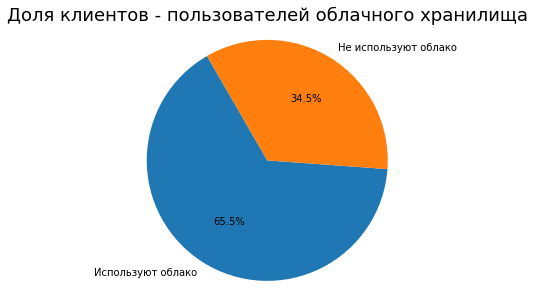

In [33]:
#Выведем диаграмму по клиентам, использующим и не использующим облачное хранилище
round(data['OnlineBackup'], 'Используют облако', 'Не используют облако', 'Доля клиентов - пользователей облачного хранилища')

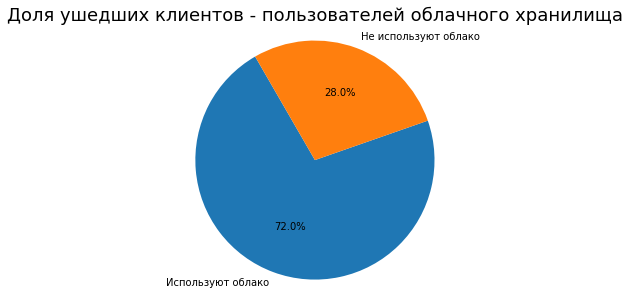

In [34]:
#Выведем диаграмму по ушедшим клиентам, использующим и не использующим облачное хранилище
round(data_leave['OnlineBackup'], 'Используют облако', 'Не используют облако', 'Доля ушедших клиентов - пользователей облачного хранилища')

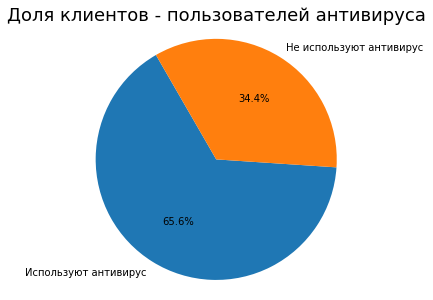

In [35]:
#Выведем диаграмму по клиентам, использующим и не использующим интивирус
round(data['DeviceProtection'], 'Используют антивирус', 'Не используют антивирус', 'Доля клиентов - пользователей антивируса')

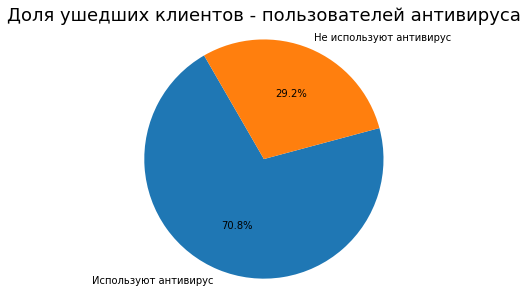

In [36]:
#Выведем диаграмму по ушедшим клиентам, использующим и не использующим интивирус
round(data_leave['DeviceProtection'], 'Используют антивирус', 'Не используют антивирус', 'Доля ушедших клиентов - пользователей антивируса')

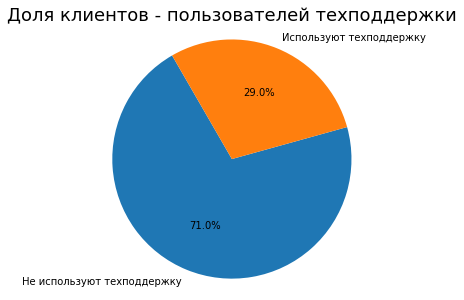

In [37]:
#Выведем диаграмму по клиентам, использующим и не использующим техподдержку
round(data['TechSupport'], 'Не используют техподдержку', 'Используют техподдержку', 'Доля клиентов - пользователей техподдержки')

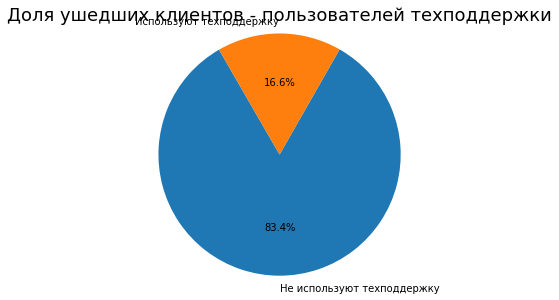

In [38]:
#Выведем диаграмму по ушедшим клиентам, использующим и не использующим техподдержку
round(data_leave['TechSupport'], 'Не используют техподдержку', 'Используют техподдержку', 'Доля ушедших клиентов - пользователей техподдержки')

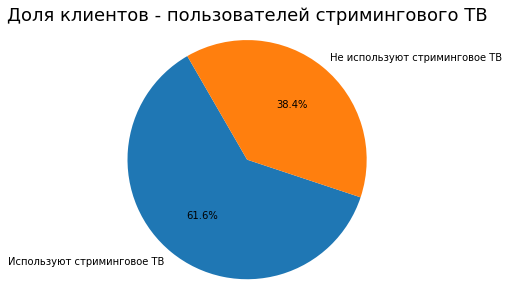

In [39]:
#Выведем диаграмму по клиентам, использующим и не использующим стриминговое телевидение
round(data['StreamingTV'], 'Используют стриминговое ТВ', 'Не используют стриминговое ТВ', 'Доля клиентов - пользователей стримингового ТВ')

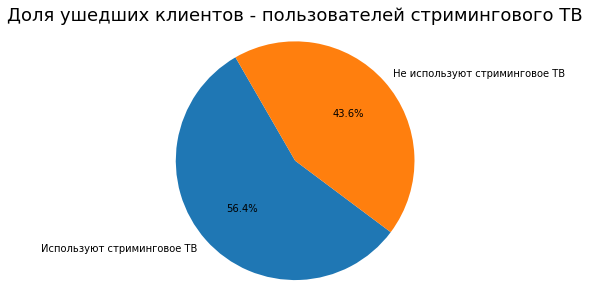

In [40]:
#Выведем диаграмму по ушедшим клиентам, использующим и не использующим стриминговое телевидение
round(data_leave['StreamingTV'], 'Используют стриминговое ТВ', 'Не используют стриминговое ТВ', 'Доля ушедших клиентов - пользователей стримингового ТВ')

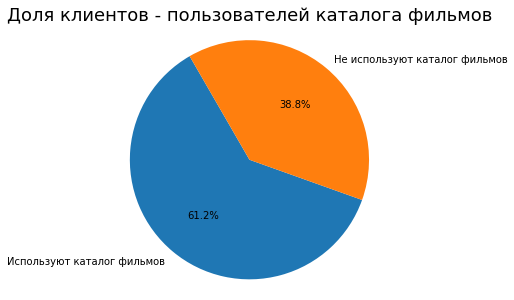

In [41]:
#Выведем диаграмму по клиентам, использующим и не использующим каталог фильмов
round(data['StreamingMovies'], 'Используют каталог фильмов', 'Не используют каталог фильмов', 'Доля клиентов - пользователей каталога фильмов')

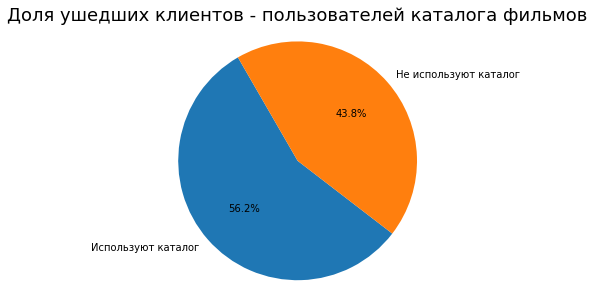

In [42]:
#Выведем диаграмму по ушедшим клиентам, использующим и не использующим каталог фильмов
round(data_leave['StreamingMovies'], 'Используют каталог', 'Не используют каталог', 'Доля ушедших клиентов - пользователей каталога фильмов')

Выше мы увидели, что доля пользователей интернета среди ушедших клиентов ощутимо выше, чем среди всей массы (+16%). Посмотрим, есть ли здесь влияние типа подключения.

In [43]:
#Добавим функцию для гистограмм на три значения признаков
def round_3(column, label1, label2, label3, title):
    labels = [label1, label2, label3,]
    sizes = column.value_counts().values
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=120)
    ax1.axis('equal')  
    plt.tight_layout()
    plt.title(title, fontsize=18)
    plt.show()

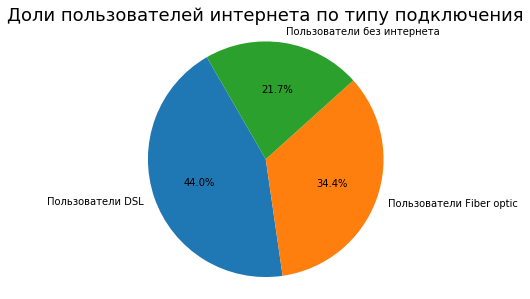

In [44]:
#Выведем гистограмму с долями пользователей по типу подключения
round_3(data['InternetService'], 'Пользователи DSL', 'Пользователи Fiber optic', 'Пользователи без интернета', 'Доли пользователей интернета по типу подключения')

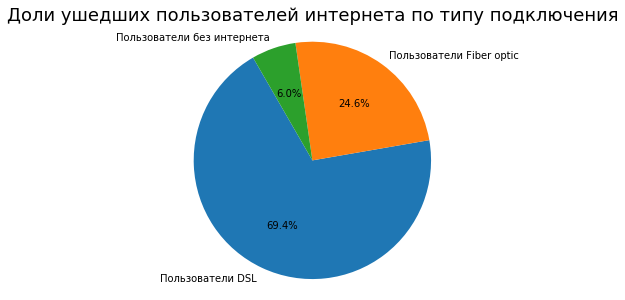

In [45]:
#Выведем гистограмму с долями ушедших пользователей по типу подключения
round_3(data_leave['InternetService'], 'Пользователи DSL', 'Пользователи Fiber optic', 'Пользователи без интернета', 'Доли ушедших пользователей интернета по типу подключения')

Диаграммы с долями пользователей интернета по типу подключения показывают, что уходят от провайдера по большей части пользователи DLS. Это логично, так как способ подключения не самый современный и удобный, видимо клиентов не устраивает качество связи.

**Вывод.** Если смотреть на доли пользователей интернета, то видим, что среди ушедших клиентов этот процент выше, чем в целом по датасету (94% против 78%). При этом, если рассматривать статистику в разрезе отдельных услуг, разница в соотношении между пользователями/непользователями среди всей массы и среди ушедших клиентов незначительная, примерно в районе 5%. Самый большой разброс - около 12% - у не-пользователей выделенной линии техподдержки.   

Также можно отметить, что доли пользователей двух услуг Стриминговое ТВ + Каталог фильмов практически идентичны как для всей массы клиентов, так и для среза по ушедшим. Не очень понятно по описанию, но вероятно эти услуги идут пакетом, почти неотъемлемы друг от друга.  

По анализу клиентов в разрезе типов подключения ясно видим, что основной процент ушедших (почти 70%) приходится на пользователей DSL-подключения. Возможно подводит качество связи, особенно, если учесть разброс у клиентов с техподдержкой.

Что касается услуги мультилиний, видимо, ее наличие не оказывает существенного влияния на решение клиента об уходе, так как соотношение долей по всем клиентам и по срезу ушедших меняется очень мало (около 3%)

<a id='3.3'></a>
### Анализ "портрета пользователя"

Рассмотрим основные "анкетные" характеристики пользователей и их связь с уходом клиентов из компании.

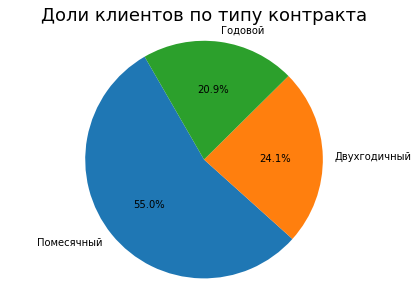

In [46]:
#Выведем диаграмму по типу контракта
round_3(data['Type'], 'Помесячный', 'Двухгодичный', 'Годовой', 'Доли клиентов по типу контракта')

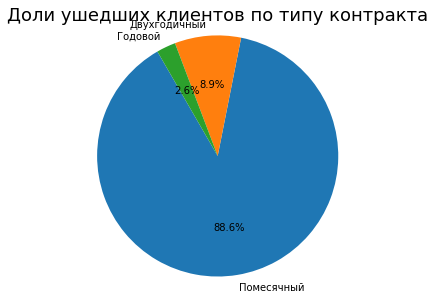

In [47]:
#Выведем диаграмму по типу контракта для ушедших клиентов
round_3(data_leave['Type'], 'Помесячный', 'Двухгодичный', 'Годовой', 'Доли ушедших клиентов по типу контракта')

Здесь видим, что подавляющее большиство (88,6%) ушедших клиентов имело контракты с ежемесячной оплатой

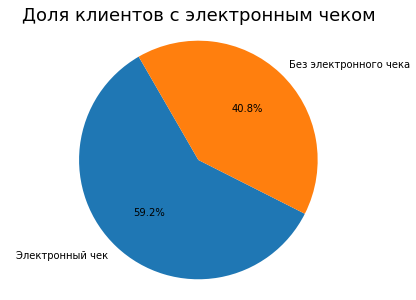

In [48]:
#Выведем диаграмму по способу получения чека
round(data['PaperlessBilling'], 'Электронный чек', 'Без электронного чека', 'Доля клиентов с электронным чеком')

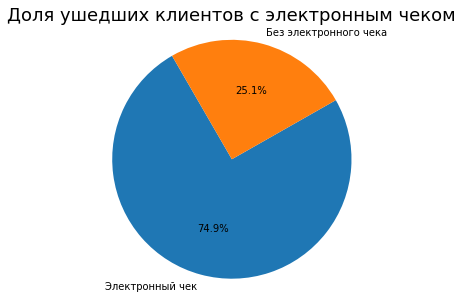

In [49]:
#Выведем диаграмму по способу получения чека для ушедших клиентов
round(data_leave['PaperlessBilling'], 'Электронный чек', 'Без электронного чека', 'Доля ушедших клиентов с электронным чеком')

Здесь видим, что уходят в основном клиенты с электронными чеками, доля таких на 15% выше, чем в общей массе клиентов. Возможно здесь дело в том, что бумажные чеки предпочитают получать более консервативные люди, не склонные к переменам (в т.ч. провайдера)

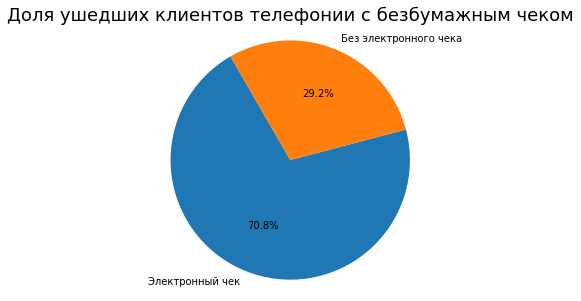

In [50]:
#Выведем диаграмму по способу получения чека для ушедших пользователей только телефонной связи
round(data.query('Leave == 1' and ('InternetUser == 0'))['PaperlessBilling'], 'Электронный чек', 'Без электронного чека', 'Доля ушедших клиентов телефонии с безбумажным чеком')

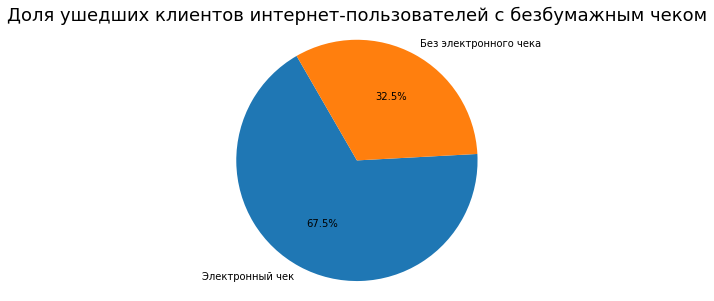

In [51]:
#Выведем диаграмму по способу получения чека для ушедших пользователей интернета
round(data.query('Leave == 1' and ('InternetUser == 1'))['PaperlessBilling'], 'Электронный чек', 'Без электронного чека', 'Доля ушедших клиентов интернет-пользователей с безбумажным чеком')

Видим, что количество ушедших клиентов с электронными чеками примерно одинаково для пользователей как с интернетом, так и без. Похоже, что связи с типом услуг здесь нет.

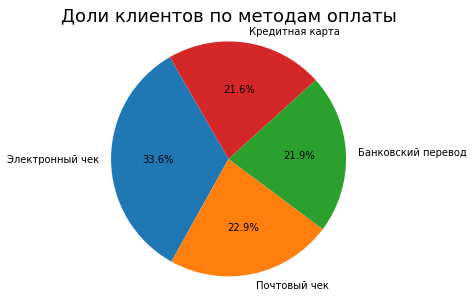

In [52]:
#Выведем диаграмму по способам оплаты
labels = ['Электронный чек', 'Почтовый чек', 'Банковский перевод', 'Кредитная карта']
sizes = data['PaymentMethod'].value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=120)
ax1.axis('equal')  
plt.tight_layout()
plt.title('Доли клиентов по методам оплаты', fontsize=18)
plt.show()

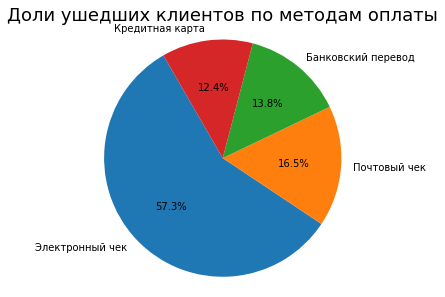

In [53]:
#Выведем диаграмму по способам оплаты для ушедших клиентов
labels = ['Электронный чек', 'Почтовый чек', 'Банковский перевод', 'Кредитная карта']
sizes = data_leave['PaymentMethod'].value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=120)
ax1.axis('equal')  
plt.tight_layout()
plt.title('Доли ушедших клиентов по методам оплаты', fontsize=18)
plt.show()

По диаграммам видно, что чаще всего уходят клиенты, оплачивающие услуги с помощью электронного чека. Это выглядит логично, т.к. перевод и карта подразумевают списание автоматом (указано в условии), почтовый чек видимо снова вариант для консерваторов, а электронный (насколько я понимаю) предполагает ручную оплату, следовательно, постоянно заставляет клиента задуматься, а стоят ли эти услуги того, чтобы и дальше за них платить)

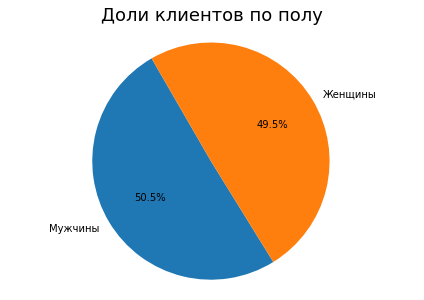

In [54]:
#Выведем диаграмму по полу клиентов
round(data['gender'], 'Мужчины', 'Женщины', 'Доли клиентов по полу')

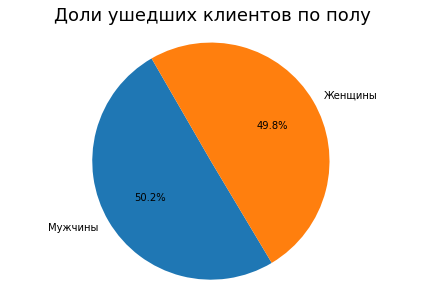

In [55]:
#Выведем диаграмму по полу ушедших клиентов
round(data_leave['gender'], 'Мужчины', 'Женщины', 'Доли ушедших клиентов по полу')

Видим, что пол клиента практически никак не влияет на уход клиента от провайдера - доли меняются на 0,3%

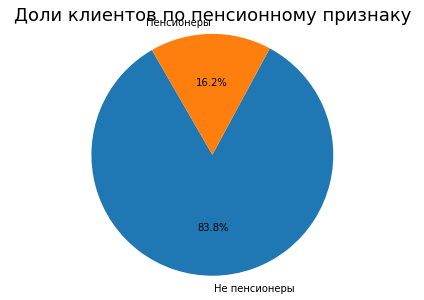

In [56]:
#Выведем диаграмму по признаку пенсионного возраста
round(data['SeniorCitizen'], 'Не пенсионеры', 'Пенсионеры', 'Доли клиентов по пенсионному признаку')

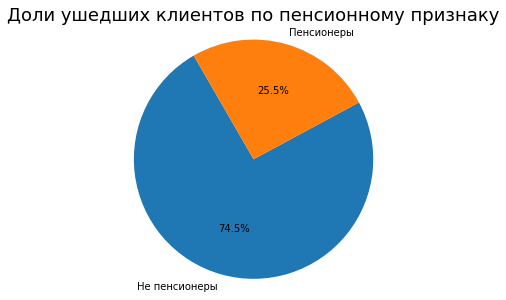

In [57]:
#Выведем диаграмму ушедших клиентов по признаку пенсионного возраста
round(data_leave['SeniorCitizen'], 'Не пенсионеры', 'Пенсионеры', 'Доли ушедших клиентов по пенсионному признаку')

Видим, что доля клиентов пенсионного возраста выше среди ушедших по сравнению с общей массой пользователей. При том, что люди постарше обычно более консервативны в привычках и не склонны часто менять операторов услуг. Похоже на то, что предоставляемые услуги не соответствуют потребностям людей старшего возраста (например, слишком высокие цены или нет тарифов с небольшим количеством трафика)

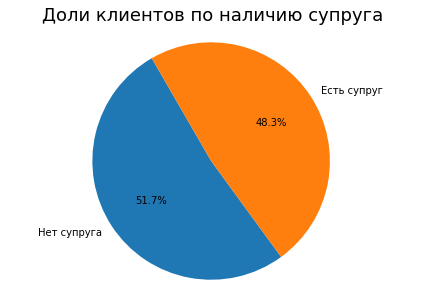

In [58]:
#Выведем диаграмму по признаку наличия супруга
round(data['Partner'], 'Нет супруга', 'Есть супруг', 'Доли клиентов по наличию супруга')

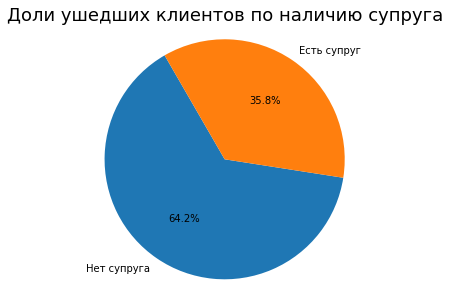

In [59]:
#Выведем диаграмму по признаку наличия супруга для ушедших клиентов
round(data_leave['Partner'], 'Нет супруга', 'Есть супруг', 'Доли ушедших клиентов по наличию супруга')

Здесь видим, что среди ушедших клиентов больше "одиночек". Люди без семьи в среднем более мобильны, и в нашем случае речь может идти в том числе не о сознательной смене оператора, а, например, о переездах и т.п.

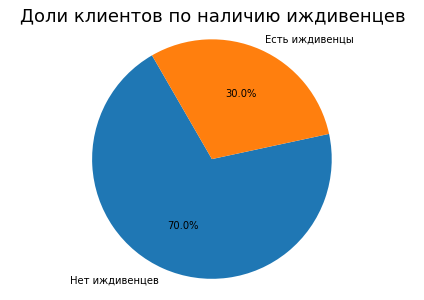

In [60]:
#Выведем диаграмму по признаку наличия иждивенцев
round(data['Dependents'], 'Нет иждивенцев', 'Есть иждивенцы', 'Доли клиентов по наличию иждивенцев')

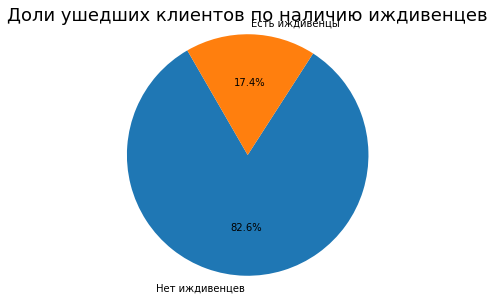

In [61]:
#Выведем диаграмму по признаку наличия иждивенцев для ушедших клиентов
round(data_leave['Dependents'], 'Нет иждивенцев', 'Есть иждивенцы', 'Доли ушедших клиентов по наличию иждивенцев')

С наличием иждивенцев ситуация примерно та же, что и с супругами - чаще уходят свободные.

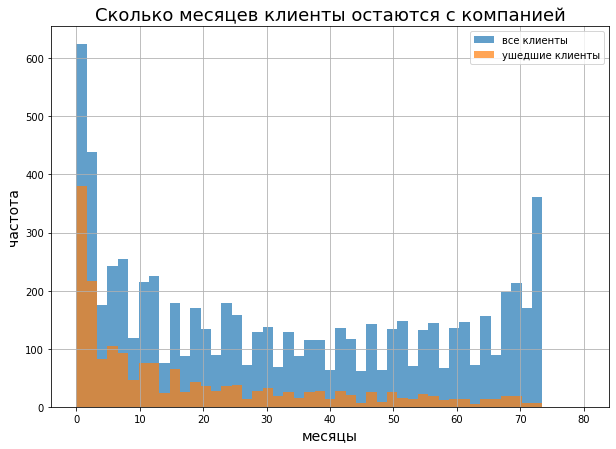

In [62]:
#Выведем гистограммы распределения кол-во месяцев клиента с компанией, две на одном графике - для ушедших и оставшихся
ax = data['Months'].plot(kind='hist', alpha=0.7, bins=np.linspace(0, 80, 50), figsize = (10,7), label='все клиенты', grid=True, legend=True)
data_leave['Months'].plot(kind='hist', alpha=0.7, bins=np.linspace(0, 80, 50), figsize = (10,7), ax=ax, label='ушедшие клиенты', grid=True, legend=True)
plt.title("Сколько месяцев клиенты остаются с компанией", fontsize = 18)
plt.ylabel("частота", fontsize = 14)
plt.xlabel("месяцы", fontsize = 14)
plt.legend()
plt.show()

Данные "по краям" графика на первый взгляд могут показаться выбросами, но в рамках задачи считаю их реалистичными, а потому оставляю как корректные. После первичного знакомства с данными мы знаем, что многие клиенты уходят после первого же месяца, это объясняет всплеск в начале графика. Также нам известно, что данные не полные, а лишь за некоторый отрезок времени, соответственно, есть клиенты, которые за этот отрезок "выходят" (т.е. были подключены раньше начальной даты, но оказались все записаны на нее), они как раз и стоят в конце.

In [63]:
#Выведем описательную статистику по месяцам
print('Статистика распределения по месяцам среди всех клиентов')
display(data['Months'].describe())
print('Статистика распределения по месяцам среди ушедших клиентов')
display(data_leave['Months'].describe())

Статистика распределения по месяцам среди всех клиентов


count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: Months, dtype: float64

Статистика распределения по месяцам среди ушедших клиентов


count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: Months, dtype: float64

**Вывод.** Анализ в этом разделе показал, что практически все признаки так или иначе связаны с уходом клиента от провайдера, так как видим изменения долей при сравнении всей массы клиентов и только ушедших. Единственный признак, доля по которому практически не изменилась - это пол клиента.  

По остальным признакам наиболее сильные изменения видим у клиентов со следующими параметрами: без супругов и иждивенцев, пенсионеров, совершающих оплату с помощью электронных чеков, получающих квитанции в электронном виде, с помесячным контрактом.  

Анализ продолжительности пребывания клиента в компании показал, что чаще всего клиенты уходят в течение первого и второго месяцев, затем еще довольно много в течение года и двух, после этого количество уходящих снижается примерно в два раза. Также на графике мы видим всплески с промежутками примерно в 12 месяцев. С первыми месяцами все понятно: новые клиенты обычно наименее лояльны. Что касается точек отсчета по 12 месяцев, то видимо это моменты окончания контрактов (годовых и двухгодовых), после которых теоретически могут быть пересмотрены условия, и если клиента новые условия не устроили - он уходит.

<a id='3.4'></a>
### Анализ денежных потоков

Проанализируем, как суммы платежей могли повлиять на уход клиента

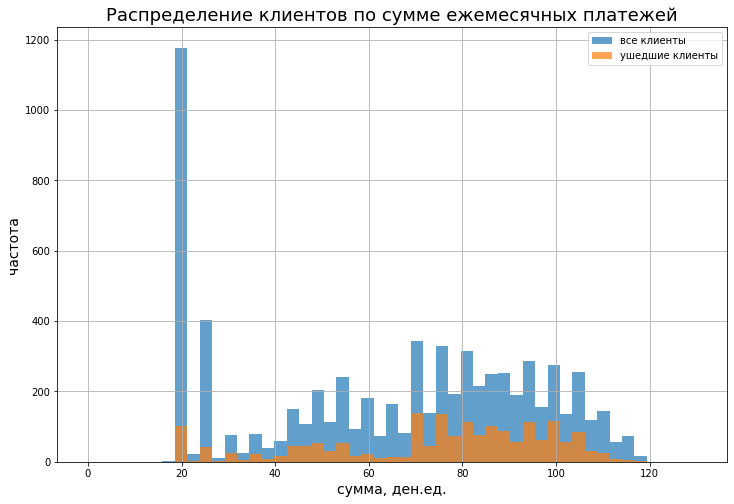

In [66]:
#Выведем распределение клиентов по сумме ежемесячных платежей, две граппы на одном графике - для ушедших и оставшихся
ax = data['MonthlyCharges'].plot(kind='hist', alpha=0.7, bins=np.linspace(0, 130, 50), figsize = (12,8), label='все клиенты', grid=True, legend=True)
data_leave['MonthlyCharges'].plot(kind='hist', alpha=0.7, bins=np.linspace(0, 130, 50), figsize = (12,8), ax=ax, label='ушедшие клиенты', grid=True, legend=True)
plt.title("Распределение клиентов по сумме ежемесячных платежей", fontsize = 18)
plt.ylabel("частота", fontsize = 14)
plt.xlabel("сумма, ден.ед.", fontsize = 14)
plt.legend()
plt.show()

In [67]:
#Выведем описательную статистику по суммам
print('Статистика распределения сумм ежемесячных платежей среди всех клиентов')
display(data['MonthlyCharges'].describe())
print('Статистика распределения сумм ежемесячных платежей среди ушедших клиентов')
display(data_leave['MonthlyCharges'].describe())

Статистика распределения сумм ежемесячных платежей среди всех клиентов


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Статистика распределения сумм ежемесячных платежей среди ушедших клиентов


count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

По этому графику можем видеть, что клиенты, которые платят выше среднего (в рамках одного оператора), уходят чаще. Но также относительно часто уходят клиенты с минимальной суммой платежа (около 20 ден.ед.). Описательная статистика показывает нам, что уходящие клиенты переплачивают по сравнению с остальной массой пользователей (возможно какие-то "лишние" услуги", возможно неудачные тарифы - о тарифах данных у нас нет)

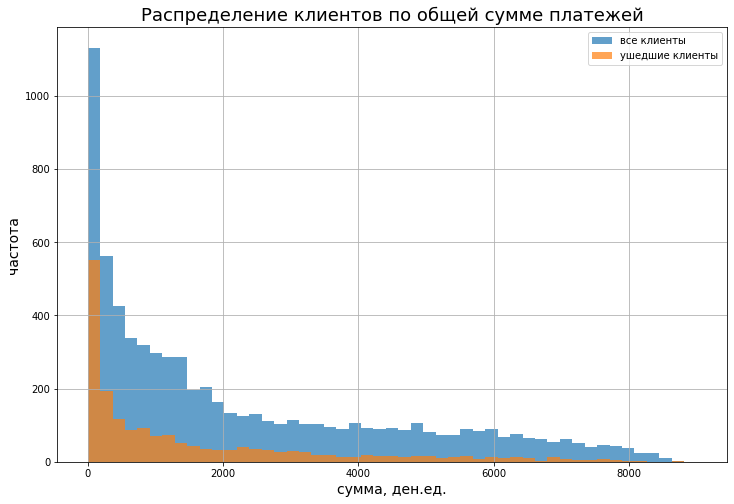

In [68]:
#Выведем распределение клиентов по общей сумме платажей, две граппы на одном графике - для ушедших и оставшихся
ax = data['TotalCharges'].plot(kind='hist', alpha=0.7, bins=np.linspace(0, 9000, 50), figsize = (12,8), label='все клиенты', grid=True, legend=True)
data_leave['TotalCharges'].plot(kind='hist', alpha=0.7, bins=np.linspace(0, 9000, 50), figsize = (12,8), ax=ax, label='ушедшие клиенты', grid=True, legend=True)
plt.title("Распределение клиентов по общей сумме платежей", fontsize = 18)
plt.ylabel("частота", fontsize = 14)
plt.xlabel("сумма, ден.ед.", fontsize = 14)
plt.legend()
plt.show()

График распределения общей суммы платежей неинформативен, так как на него в большей степени оказывает влияние "срок жизни" клиента в компании. В целом мне кажется, что эта колонка лишняя для анализа и тем более для модели, т.к. фактически она дублирует информацию из других (произведение ежемесячной суммы платежа на кол-во месяцев в компании). Далее ее рассматривать не буду.

Ранее мы выявили несколько самых "недовольных услугами" групп клиентов, посмотрим, не переплачивают ли они по сравнению с остальными

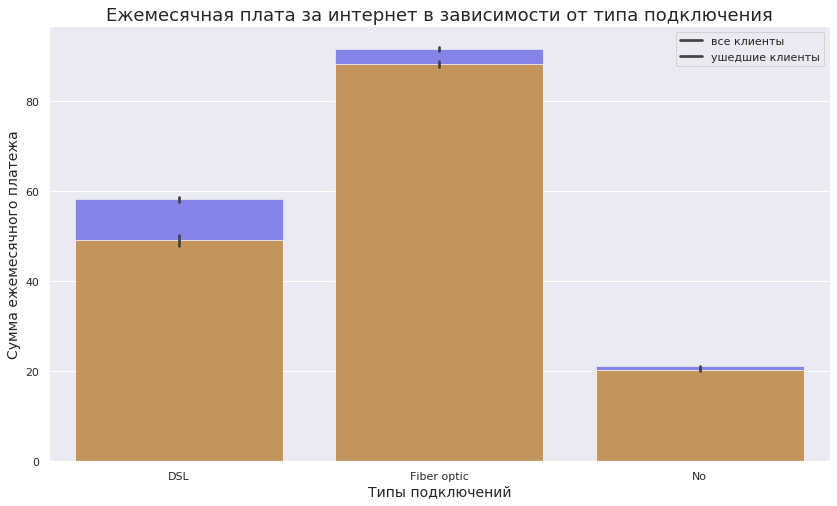

In [69]:
#Выведем график зависимости ежемесячных платежей от типа подключения
sns.set()
plt.figure(figsize = (14,8))
ax = sns.barplot(data=data, x='InternetService', y='MonthlyCharges', alpha=0.5, color ='blue',);
sns.barplot(data=data_leave, x='InternetService', y='MonthlyCharges', alpha=0.7, color ='orange');
plt.title('Ежемесячная плата за интернет в зависимости от типа подключения', fontsize=18)
plt.xlabel('Типы подключений', fontsize=14)
plt.ylabel('Сумма ежемесячного платежа', fontsize=14)
plt.legend(['все клиенты', 'ушедшие клиенты'])
plt.show()

Видим, что пользователи DLS соединения платят как минимм на треть меньше, чем пользователи оптоволоконного. По ушедшим пользователям этой услуги видно, что они платили даже меньше. То есть видимо здесь дело не в дорогом тарифе, а именно в качестве самой связи.

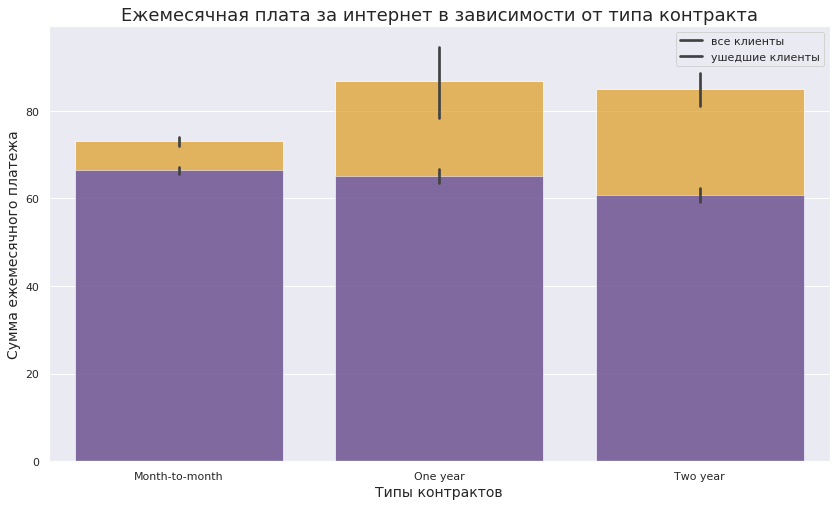

In [70]:
#Выведем график зависимости ежемесячных платежей от типа контракта
sns.set()
plt.figure(figsize = (14,8))
ax = sns.barplot(data=data_leave, x='Type', y='MonthlyCharges', alpha=0.7, color ='orange');
sns.barplot(data=data, x='Type', y='MonthlyCharges', alpha=0.5, color ='blue');
plt.title('Ежемесячная плата за интернет в зависимости от типа контракта', fontsize=18)
plt.xlabel('Типы контрактов', fontsize=14)
plt.ylabel('Сумма ежемесячного платежа', fontsize=14)
plt.legend(['все клиенты', 'ушедшие клиенты'])
plt.show()

График зависимости суммы ежемесячного платежа от типа контракта выглядит немного странно. Для всей массы клиентов суммы ежемесячного платежа различаются незначительно, при этом самым низким является платеж при двухгодичном контракте.  

У ушедших же клиентов разница между суммами более существенная. При этом самая низкая оплата - при ежемесячном контракте. По двум другим контрактам - оплата почти на треть выше, чем у всей массы пользователей. Это все наводит на мысль на какие-то акции или просто изменения тарифов, благодаря чему часть пользователей оказалась в невыгодном положении, и это привело к ее уходу.

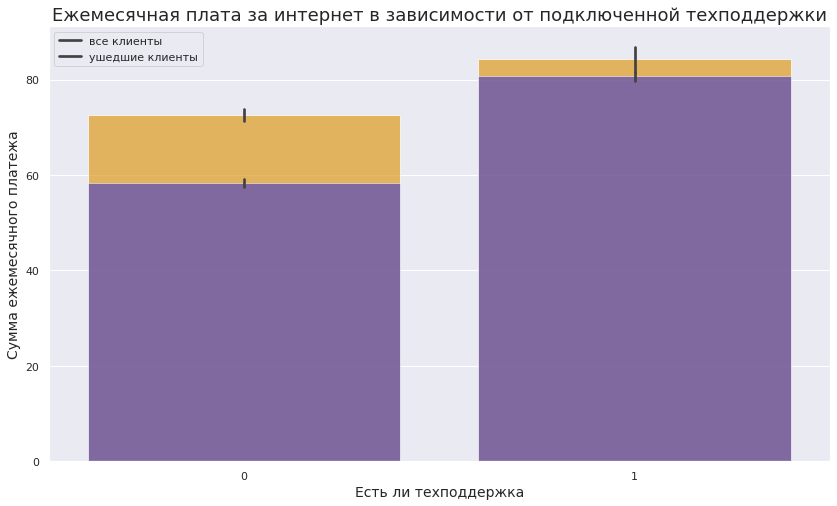

In [71]:
#Выведем график зависимости ежемесячных платежей от наличия услуги техподдержки
sns.set()
plt.figure(figsize = (14,8))
ax = sns.barplot(data=data_leave, x='TechSupport', y='MonthlyCharges', alpha=0.7, color ='orange');
sns.barplot(data=data, x='TechSupport', y='MonthlyCharges', alpha=0.5, color ='blue');
plt.title('Ежемесячная плата за интернет в зависимости от подключенной техподдержки', fontsize=18)
plt.xlabel('Есть ли техподдержка', fontsize=14)
plt.ylabel('Сумма ежемесячного платежа', fontsize=14)
plt.legend(['все клиенты', 'ушедшие клиенты'])
plt.show()

Видим, что клиенты с подключенной техподдержкой платят ощутимо выше. При этом ушедшие клиенты также переплачивают по сравнению с общей массой. Но здесь нельзя сказать, что дело именно в техподдержке, поскольку клиенты без нее переплачивают еще больше.

<a id='3.5'></a>
### Вывод по исследовательскому анализу

Анализ данных показал:  

1. За рассматриваемый период из компании ушло 26,5% клиентов.
2. Практически все ушедшие клиенты (94%) являлись пользователями интернета, и из них около 70% - подключенные через DLS.
3. Большая часть клиентов (около 70%) пользовалась электронными чеками в качестве средства платежа и подтверждающего документа.
4. По типу контракта 88,6% ушедших были подписаны на ежемесячный.
5. Что касается социального портрета, то среди ушедших значительно больше клиентов без супругов и иждивенцев.
6. Также выявлено, что ушли в основном клиенты, которые платили за услуги больше среднего по компании. Кроме того, отмечено, что за аналогичные по времени контракты они переплачивали.
7. Наиболее сильная корреляция выявлена между затратами (за месяц и всего), а также затратами и услугами интернета.

Отсюда делаю следующие предположения:  

1. Найдены дублирующие/не несущие информации данные, эти признаки мы затем удалим, чтобы не загромождать модель: customerID, TotalCharges (фактически дублирует Montly * кол-во месяцев), gender (практически поровну), InternetUser (был добавлен для визуализации, далее удалю его, чтобы не подсказывал моделям)
2. Анализ показал, что категорийные переменные имеют существенное значение для ухода/неухода клиента. Однако не все модели умеют работать с ними, поэтому перед обучением нужно будет применить технику OHE для кодирования следующих переменных: Type, PaymentMethod, InternetService (убрать NO, разбить только на две колонки - т.к. дублирует InternetUser), 
3. В целевом признаке наблюдается довольно сильный дисбаланс классов, необходимо будет применить меры для борьбы с ним - метод Upsampling и балансировку в параметрах моделей

На будущее сразу отмечу потенциальные точки роста и возможности для удержания клиентов:  

1. Сейчас мы будем строить модель для предсказания ухода. Но также желательно предсказать причину, чтобы предложить клиенту подходящие именно ему условия.
2. Сделать несколько групп промокодов в зависимости от причины возможного ухода. Например, если определяем, что клиент переплачивает по сравнению с остальными - скидка или акция на долгий тарифный план. Если у него DSL - предлагаем более современный и быстрый способ подключения, бесплатную техподдержку и т.п.

<a id='4'></a>
## Подготовка данных

<a id='4.1'></a>
### Удаление лишнего

Уберу признаки, которые выше определила как лишние в ходе анализа: customerID, TotalCharges, gender.
Также удалю колонку InternetUser, она была добавлена для визуализации анализа и может дать модели "чит", т.к. она вычислена на основе других

In [72]:
data = data.drop(['customerID','TotalCharges', 'gender', 'InternetUser'], axis=1)

<a id='4.2'></a>
### Кодирование категориальных признаков

Анализ данных показал, что категориальные признаки имеют существенное значение для ухода клиента, поэтому нам важно учесть их в моделях. Кодируем их методом OHE, чтобы все модели могли справиться

In [73]:
#Кодируем категориальные признаки методом ohe
data_ohe = pd.get_dummies(data, columns = ['Type', 'InternetService','PaymentMethod'], drop_first = True)

In [74]:
data_ohe.head()

,PaperlessBilling,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Leave,Months,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,56.95,0,0,0,0,1,0,1,0,0,0,0,34,1,0,0,0,0,0,1
2,1,53.85,0,0,0,0,1,1,0,0,0,0,1,2,0,0,0,0,0,0,1
3,0,42.30,0,0,0,0,1,0,1,1,0,0,0,45,1,0,0,0,0,0,0
4,1,70.70,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,0,0,1,0


In [75]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
PaperlessBilling                         7043 non-null int64
MonthlyCharges                           7043 non-null float64
SeniorCitizen                            7043 non-null int64
Partner                                  7043 non-null int64
Dependents                               7043 non-null int64
MultipleLines                            7043 non-null int64
OnlineSecurity                           7043 non-null int64
OnlineBackup                             7043 non-null int64
DeviceProtection                         7043 non-null int64
TechSupport                              7043 non-null int64
StreamingTV                              7043 non-null int64
StreamingMovies                          7043 non-null int64
Leave                                    7043 non-null int64
Months                                   7043 non-null int64
Type_One year                        

<a id='4.3'></a>
### Разбиение на выборки и подготовка признаков

В нашем проекте отсутствует скрытая тестовая выборка. Следовательно будем делить данные на 3 части в следующих пропорциях:
* обучающая выборка - 60%
* валидационная выборка - 20%
* тестовая выборка - 20%  

Чтобы количество классов было распределено по выборкам равномерно, используем при разбиении аргумент stratify

<a id='4.3.1'></a>
#### Кодированные выборки

In [76]:
#Выделим целевой признак и остальные
target = data_ohe['Leave']
features = data_ohe.drop('Leave', axis=1)

In [77]:
#Отделим 60% для тестовой выборки
features_train, features_valid, target_train, target_valid = train_test_split(features, target, train_size=0.6, random_state=12345, stratify = target)

In [78]:
#Теперь делим пополам вторую часть, чтобы получить по 20% для валидационной и тестовой выборок
features_test, features_valid, target_test, target_valid = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345, stratify = target_valid)

In [79]:
#Проверим размеры полученных выборок
def test_percent(df1,df2,df3):
    p1 = df1.shape[0]/data_ohe.shape[0]
    p2 = df2.shape[0]/data_ohe.shape[0]
    p3 = df3.shape[0]/data_ohe.shape[0]
    print('{:.0%} {:.0%} {:.0%}'.format(p1,p2,p3))
test_percent(features_train, features_test, features_valid)

60% 20% 20%


<a id='4.3.2'></a>
#### Некодированные выборки

Также нам понадобятся выборки из исходного датасета (до кодировки) - для того, чтобы задействовать внутренние механизмы работы с категориальными признаками у моделей CatBoost и LightGBM

In [80]:
#Выделим целевой признак и остальные для исходного датасета
target_raw = data['Leave']
features_raw = data.drop('Leave', axis=1)

In [81]:
#Отделим 60% для тестовой выборки  для исходного датасета
features_train_raw, features_valid_raw, target_train_raw, target_valid_raw = train_test_split(features_raw, target_raw, train_size=0.6, random_state=12345, stratify = target_raw)

In [82]:
#Теперь делим пополам вторую часть, чтобы получить по 20% для валидационной и тестовой выборок для исходного датасета
features_test_raw, features_valid_raw, target_test_raw, target_valid_raw = train_test_split(features_valid_raw, target_valid_raw, test_size=0.5, random_state=12345, stratify = target_valid_raw)

In [83]:
#Проверим размеры полученных выборок для исходного датасета
def test_percent(df1,df2,df3):
    p1 = df1.shape[0]/data_ohe.shape[0]
    p2 = df2.shape[0]/data_ohe.shape[0]
    p3 = df3.shape[0]/data_ohe.shape[0]
    print('{:.0%} {:.0%} {:.0%}'.format(p1,p2,p3))
test_percent(features_train_raw, features_test_raw, features_valid_raw)

60% 20% 20%


In [84]:
#Скорер для проверки моделей
scorer = make_scorer(roc_auc_score)

<a id='4.3.3'></a>
#### Масштабирование признаков

In [85]:
#Соберем словарь из всех численных признаков
numeric = ['MonthlyCharges', 'Months']

In [86]:
#Настроим стандартизацию на обучающей выборке
scaler = StandardScaler()
scaler.fit(features_train[numeric])

#Отключаем предупреждение SettingWithCopy
pd.options.mode.chained_assignment = None

#Сохраним преобразованные выборки в соответствующих переменных для декордированных и недекодированных датасетов
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train_raw[numeric] = scaler.transform(features_train_raw[numeric])
features_valid_raw[numeric] = scaler.transform(features_valid_raw[numeric])
features_test_raw[numeric] = scaler.transform(features_test_raw[numeric])
#Посмотрим, что получилось
features_train.head()

,PaperlessBilling,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Months,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6295,0,-1.483755,0,1,1,0,0,0,0,0,0,0,0.612772,0,1,0,1,0,0,0
6630,1,0.458464,1,0,0,0,0,0,0,0,0,1,-0.683795,0,0,1,0,0,1,0
888,0,0.871454,0,1,1,0,0,0,0,0,1,1,0.167077,1,0,1,0,1,0,0
3124,0,0.594469,0,1,1,0,1,1,0,1,1,1,1.423126,0,1,0,0,0,0,0
4274,0,-1.528537,0,0,0,0,0,0,0,0,0,0,0.491219,1,0,0,1,0,0,0


<a id='4.3.4'></a>
#### Масштабирование признаков для кодированной выборки

In [87]:
#Поделим обучающую выборку на объекты каждого класса
features_zeros = features_train[target_train == 0] 
features_ones = features_train[target_train == 1] 
target_zeros = target_train[target_train == 0] 
target_ones = target_train[target_train == 1]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(3104, 20)
(1121, 20)
(3104,)
(1121,)


In [88]:
#Перемешаем данные после апсемплинга и сохраним их в новых переменных
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
 
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(features_upsampled.shape)
print(target_upsampled.shape)

(6467, 20)
(6467,)


In [89]:
#Отделим 60% для тестовой выборки
features_train_upsampled, features_valid_upsampled, target_train_upsampled, target_valid_upsampled = train_test_split(features_upsampled, target_upsampled, train_size=0.6, random_state=12345, stratify = target_upsampled)
#Теперь делим пополам вторую часть, чтобы получить по 20% для валидационной и тестовой выборок
features_test_upsampled, features_valid_upsampled, target_test_upsampled, target_valid_upsampled = train_test_split(features_valid_upsampled, target_valid_upsampled, test_size=0.5, random_state=12345, stratify = target_valid_upsampled)

<a id='4.3.5'></a>
#### Масштабирование признаков для кодированной выборки

In [90]:
#Поделим обучающую выборку на объекты каждого класса
features_zeros_raw = features_train_raw[target_train_raw == 0] 
features_ones_raw = features_train_raw[target_train_raw == 1] 
target_zeros_raw = target_train_raw[target_train_raw == 0] 
target_ones_raw = target_train_raw[target_train_raw == 1]

In [92]:
features_upsampled_raw, target_upsampled_raw = upsample(features_train_raw, target_train_raw, 3)

print(features_upsampled_raw.shape)
print(target_upsampled_raw.shape)

(6467, 16)
(6467,)


In [93]:
#Отделим 60% для тестовой выборки
features_train_upsampled_raw, features_valid_upsampled_raw, target_train_upsampled_raw, target_valid_upsampled_raw = train_test_split(features_upsampled_raw, target_upsampled_raw, train_size=0.6, random_state=12345, stratify = target_upsampled_raw)
#Теперь делим пополам вторую часть, чтобы получить по 20% для валидационной и тестовой выборок
features_test_upsampled_raw, features_valid_upsampled_raw, target_test_upsampled_raw, target_valid_upsampled_raw = train_test_split(features_valid_upsampled_raw, target_valid_upsampled_raw, test_size=0.5, random_state=12345, stratify = target_valid_upsampled_raw)

<a id='5'></a>
## Обучение моделей

<a id='5.1'></a>
### Константная модель

In [94]:
#Создадим константную модель для сравнения и оценки адекватности будущих обученных моделей
target_pred_constant = pd.Series([0]*len(target_upsampled))
accuracy_constant = accuracy_score(target_upsampled, target_pred_constant)

#Выведем ее метрику
print('Accuracy константной модели: ', accuracy_constant)

Accuracy константной модели:  0.4799752590072677


<a id='5.2'></a>
### Решающее дерево

In [95]:
Подберем лучшие гиперпараметры
params_dtc = {
   'max_depth': range(1, 50),
   'min_samples_split': range(2, 20), 
   'min_samples_leaf': range(1, 5)
   }


dtc = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
grid_dtc = GridSearchCV(estimator=dtc, param_grid=params_dtc, cv=5, scoring=scorer)
grid_dtc.fit(features_train, target_train)


print("Лучшие гиперпараметры: ", grid_dtc.best_params_)

In [95]:
%%time
dtc_best = DecisionTreeClassifier(max_depth=6, min_samples_split=18, min_samples_leaf=4, random_state=12345, class_weight='balanced')
dtc_best.fit(features_train_upsampled, target_train_upsampled)

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 10.1 ms


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=18,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

In [96]:
%%time
predictions_dtc_best = dtc_best.predict(features_valid_upsampled)

CPU times: user 2.51 ms, sys: 674 µs, total: 3.18 ms
Wall time: 1.93 ms


In [97]:
#введем функцию для расчета метрик
def metrics(predicted_valid_model, model, target_valid, features_valid):
    accuracy = accuracy_score(target_valid, predicted_valid_model)
    probabilities_valid = model.predict_proba(features_valid)[:,1]
    roc_auc = roc_auc_score(target_valid, probabilities_valid)
    print('Accuracy модели: ', accuracy)
    print('AUC-ROC модели: ', roc_auc)
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid) 
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая случайной модели')
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая лучшей обученной модели')
    plt.show()

Accuracy модели:  0.7921174652241113
AUC-ROC модели:  0.8516197572338149


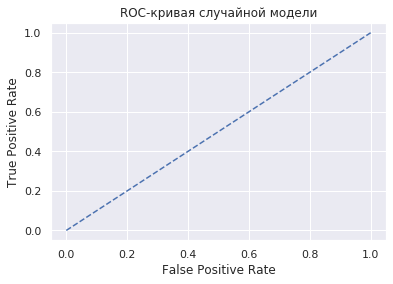

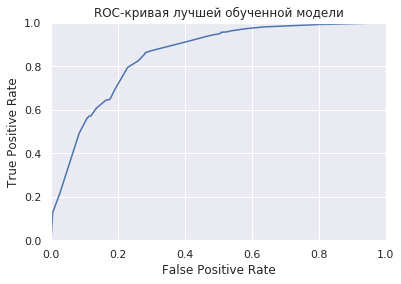

In [98]:
#Рассчитаем метрики для обученной модели решающего дерева
metrics(predictions_dtc_best, dtc_best, target_valid_upsampled, features_valid_upsampled)

Метрика auc-roc у модели решающего дерева получилась хорошей - 0.85 (уже пробивает средние пороги для проекта). При этом значение метрики accuracy тоже хорошее - 0.79

In [99]:
#Введем функцию для построения матрицы ошибок
def matrix(predicted_valid_model, target_valid, features_valid):
    matrix_model = confusion_matrix(target_valid, predicted_valid_model)
    matrix_model = pd.DataFrame(matrix_model)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(matrix_model, annot=True, annot_kws={"size":15}, cmap="Reds", vmin=0, vmax=800, fmt='.0f', xticklabels=["ушел", "остался"], yticklabels=["ушел", "остался"])
    plt.title("Матрица ошибок для лучшей обученной модели", fontsize = 18)
    plt.ylabel("ответы", fontsize = 14)
    plt.xlabel("предсказания", fontsize = 14)
    ax.set_xticklabels(["0", "1"], fontsize = 14)
    ax.set_yticklabels(["0", "1"], fontsize = 14)
    plt.show()

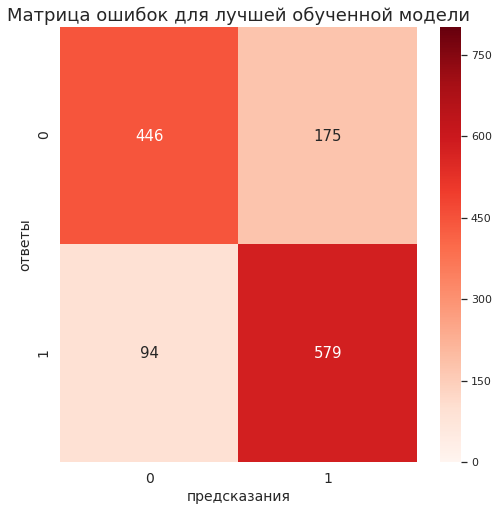

In [100]:
#Посмтроим матрицу ошибок для обученной модели решающего дерева
matrix(predictions_dtc_best, target_valid_upsampled, features_valid_upsampled)

По матрице видим, что модель решающего дерева дает 446 истинно отрицательных ответов, 579 истинно положительных, 175 ложноположительных и 94 ложноотрицательных. Видим, что процент ложных ответов у модели достаточно велик, она является чересчур оптимистичной, т.к. дает довольно большой процент ложноположительных предсказаний

<a id='5.3'></a>
### Случайный лес

In [102]:
Подберем лучшие гиперпараметры
params_rfc = {
   'max_depth': range(1, 50),
   'min_samples_split': range(2, 20), 
   'min_samples_leaf': range(1, 5),
   }


rfc = RandomForestClassifier(random_state=12345)
grid_rfc = GridSearchCV(estimator=rfc, param_grid=params_rfc, cv=5, scoring=scorer)
grid_rfc.fit(features_train, target_train)


print("Лучшие гиперпараметры: ", grid_rfc.best_params_)

In [101]:
%%time
rfc_best = RandomForestClassifier(max_depth=10, min_samples_split=18, min_samples_leaf=2, random_state=12345)
rfc_best.fit(features_train_upsampled, target_train_upsampled)

CPU times: user 31.4 ms, sys: 684 µs, total: 32.1 ms
Wall time: 30.5 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=18,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [102]:
%%time
predictions_rfc_best = rfc_best.predict(features_valid_upsampled)

CPU times: user 5.63 ms, sys: 0 ns, total: 5.63 ms
Wall time: 4.53 ms


Accuracy модели:  0.8129829984544049
AUC-ROC модели:  0.8818578575991847


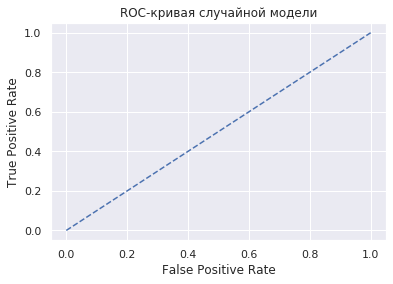

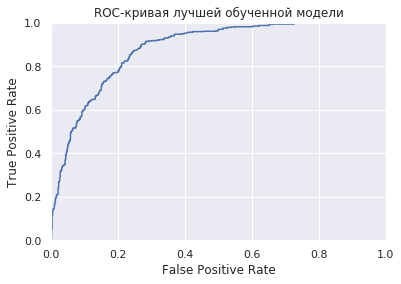

In [103]:
#Рассчитаем метрики для обученной модели случайного леса
metrics(predictions_rfc_best, rfc_best, target_valid_upsampled, features_valid_upsampled)

Метрика auc-roc у модели случайного леса подросла по сравнению с решающим деревом - 0.882 - и пробила нужный для проекта порог. Метрика accuracy тоже выше - 0.813

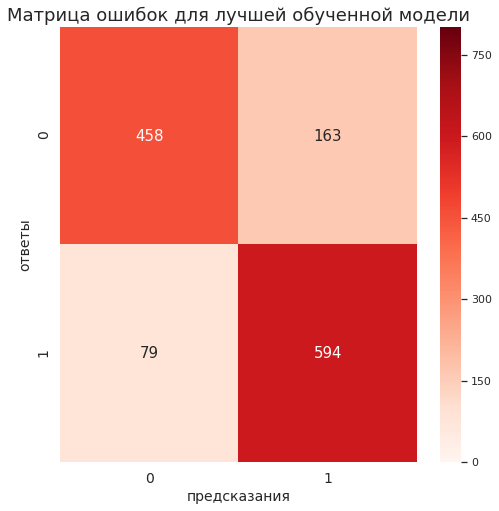

In [104]:
#Посмтроим матрицу ошибок для обученной модели решающего дерева
matrix(predictions_rfc_best, target_valid_upsampled, features_valid_upsampled)

По матрице ошибок модель случайного леса выглядит немного точнее, чем решающее дерево. Но в целом структура совершенно такая же - лес также грешит оптимизмом

<a id='5.4'></a>
### Логистическая регрессия

In [105]:
Подберем лучшие гиперпараметры
params_lr = {
   'penalty': ['l1', 'l2'],
   'max_iter': range(100, 200), 
   }


lr = LogisticRegression(random_state=12345, class_weight='balanced')
grid_lr = GridSearchCV(estimator=lr, param_grid=params_lr, cv=5, scoring=scorer)
grid_lr.fit(features_train, target_train)


print("Лучшие гиперпараметры: ", grid_lr.best_params_)

In [106]:
%%time
lr_best = LogisticRegression(penalty='l2', max_iter=100, random_state=12345, class_weight='balanced')
lr_best.fit(features_train_upsampled, target_train_upsampled)

CPU times: user 13.1 ms, sys: 193 µs, total: 13.3 ms
Wall time: 12 ms


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [107]:
%%time
predictions_lr_best = lr_best.predict(features_valid_upsampled)

CPU times: user 0 ns, sys: 17 ms, total: 17 ms
Wall time: 4.22 ms


Accuracy модели:  0.7820710973724884
AUC-ROC модели:  0.8600230180435622


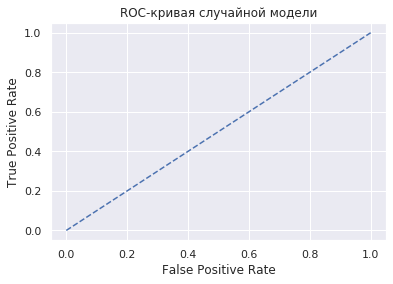

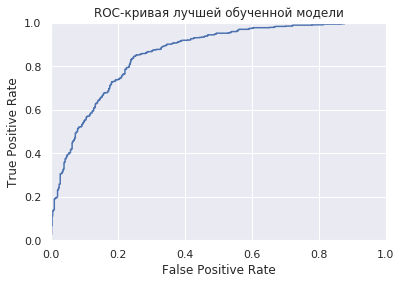

In [108]:
#Рассчитаем метрики для обученной модели логистической регрессии
metrics(predictions_lr_best, lr_best, target_valid_upsampled, features_valid_upsampled)

Видим, что модель логистической регрессии показывает качество между решающим деревом и случайным лесом. Метрика auc-roc - 0.86, a accuracy - 0.78. Показатель пониже, чем желательно получить для проекта

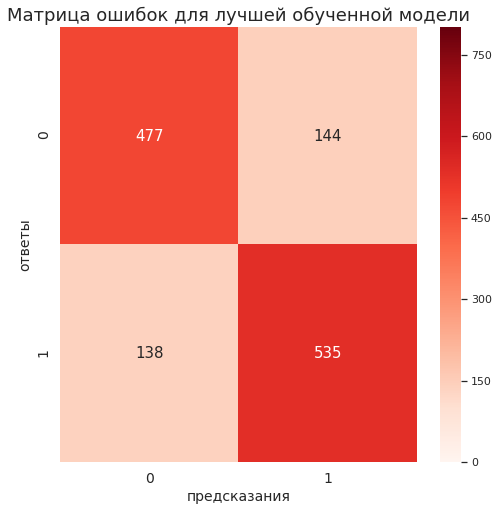

In [109]:
#Посмтроим матрицу ошибок для обученной модели решающего дерева
matrix(predictions_lr_best, target_valid_upsampled, features_valid_upsampled)

У логистической регрессии та же структура ответов по матрице ошибок, однако нужно отметить, что по сравнению с предыдущими моделями здесь выросло кол-во ложноотрицательных ответов - оно почти одинаково с ложноположительными

<a id='5.5'></a>
### CatBoost

In [110]:
#Добавим категорийные признаки для обработки "внутри" модели
cat_features = ['Type', 'PaymentMethod', 'InternetService']

In [111]:
Подберем лучшие гиперпараметры
params_cat = {
   'depth': [4, 6, 8],
   'iterations': [100, 200, 500, 600],
   'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5]
   }

cat = CatBoostClassifier()
grid_cat = GridSearchCV(estimator=cat, param_grid=params_cat, cv=5, scoring=scorer)
grid_cat.fit(features_train, target_train, verbose=5, cat_features=cat_features)

print("Лучшие гиперпараметры: ", grid_cat.best_params_)

In [112]:
%%time
cat_best = CatBoostClassifier(depth=6, iterations=600, learning_rate=0.5, verbose=False, random_state=12345)
cat_best.fit(features_train_upsampled_raw, target_train_upsampled_raw, cat_features=cat_features)

CPU times: user 19.3 s, sys: 3.66 s, total: 23 s
Wall time: 24.4 s


In [113]:
%%time
predictions_cat_best = cat_best.predict(features_valid_upsampled_raw)

CPU times: user 13.8 ms, sys: 1.06 ms, total: 14.8 ms
Wall time: 6.06 ms


Accuracy модели:  0.857032457496136
AUC-ROC модели:  0.9284741812682895


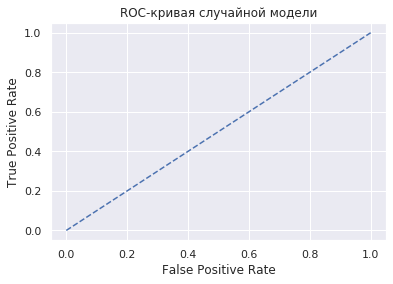

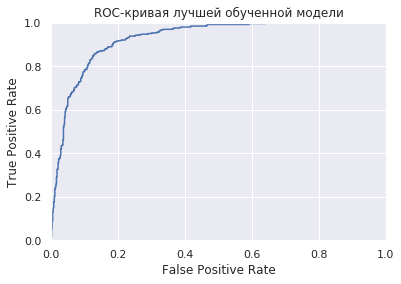

In [114]:
#Рассчитаем метрики для обученной модели CatBoost
metrics(predictions_cat_best, cat_best, target_valid_upsampled_raw, features_valid_upsampled_raw)

У модели CatBoost - самый высокий результат из опробованного. Метрика auc-roc - 0.928 (что ощутимо превышает желаемый порог), accuracy - 0.857

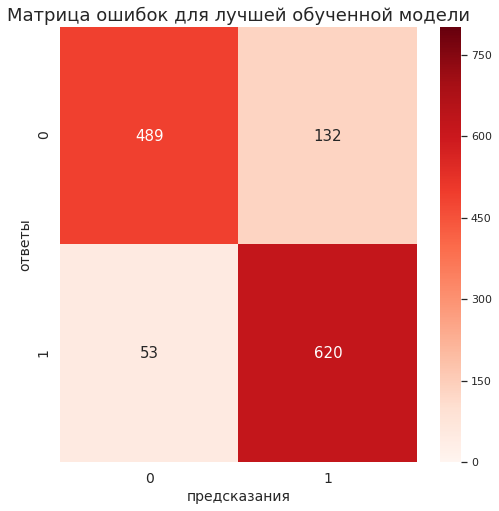

In [115]:
#Построим матрицу ошибок для обученной модели LGBM
matrix(predictions_cat_best, target_valid_upsampled_raw, features_valid_upsampled_raw)

Видимо по матрице ошибок, что модель сохраняет ту же структуру, что и остальных - склонность к оптимизму. При этом ошибок по всем параметрам меньше всего, а кол-во истинно положительных ответов - самое большое

<a id='5.6'></a>
### LGBMClassifier

In [116]:
cat_features = ['Type', 'PaymentMethod', 'InternetService']
for column in cat_features:
    features_train_upsampled_raw[column] = features_train_upsampled_raw[column].astype('category')
    features_test_upsampled_raw[column] = features_test_upsampled_raw[column].astype('category')
    features_valid_upsampled_raw[column] = features_valid_upsampled_raw[column].astype('category')

In [117]:
features_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 6295 to 1127
Data columns (total 16 columns):
Type                4225 non-null object
PaperlessBilling    4225 non-null int64
PaymentMethod       4225 non-null object
MonthlyCharges      4225 non-null float64
SeniorCitizen       4225 non-null int64
Partner             4225 non-null int64
Dependents          4225 non-null int64
MultipleLines       4225 non-null int64
InternetService     4225 non-null object
OnlineSecurity      4225 non-null int64
OnlineBackup        4225 non-null int64
DeviceProtection    4225 non-null int64
TechSupport         4225 non-null int64
StreamingTV         4225 non-null int64
StreamingMovies     4225 non-null int64
Months              4225 non-null float64
dtypes: float64(2), int64(11), object(3)
memory usage: 561.1+ KB


In [118]:
Подберем лучшие гиперпараметры
params_light = {
   'learning_rate': [0.03, 0.1, 0.5],
   'max_depth': range(-5, -1),
   'n_estimators':[50, 100, 300]
   }

light = LGBMClassifier(random_state=12345, class_weight='balanced')
grid_light = GridSearchCV(estimator=light, param_grid=params_light, cv=5, scoring=scorer)
grid_light.fit(features_train_raw, target_train_raw)

print("Лучшие гиперпараметры: ", grid_light.best_params_)

In [119]:
%%time
light_best = LGBMClassifier(learning_rate=0.3, max_depth=-1, n_estimators=300, class_weight='balanced', random_state=12345)
light_best.fit(features_train_upsampled_raw, target_train_upsampled_raw)

CPU times: user 7.75 s, sys: 0 ns, total: 7.75 s
Wall time: 7.74 s


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.3,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
               objective=None, random_state=12345, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [120]:
%%time
predictions_light_best = light_best.predict(features_valid_upsampled_raw)

CPU times: user 60.7 ms, sys: 0 ns, total: 60.7 ms
Wall time: 92.6 ms


Accuracy модели:  0.8763523956723338
AUC-ROC модели:  0.9385044971323153


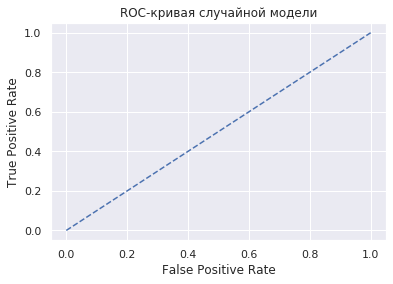

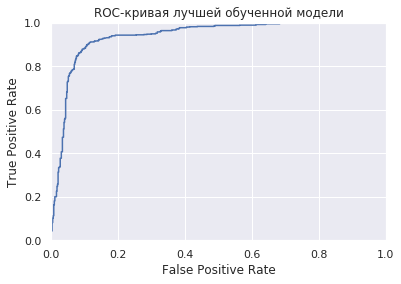

In [121]:
#Рассчитаем метрики для обученной модели LGBM
metrics(predictions_light_best, light_best, target_valid_upsampled_raw, features_valid_upsampled_raw)

Модель LightGBM дала самый высокий уровень качества из всех. Метрика auc-roc - 0.938, accuracy - 0.876

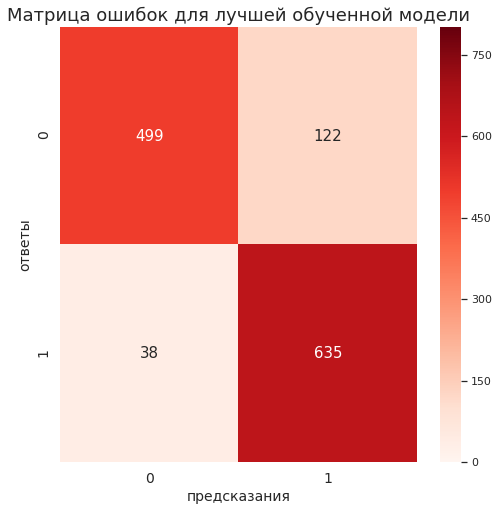

In [122]:
#Построим матрицу ошибок для обученной модели LGBM
matrix(predictions_light_best, target_valid_upsampled_raw, features_valid_upsampled_raw)

Матрица ошибок этой модели также демонстрирует самые лучшие результаты из всех. Модель по-прежнему остается немного оптимистичной, но количество правильных ответов и ошибок здесь достигли лучших показателей

**Вывод.** По результатам на обучающей выборке порог метрики AUC-ROC перешагнули три модели: RandomForest, CatBoost, LightGBM. Далее прогоним эти модели на тестовых выборках и определим фаворита

<a id='6'></a>
## Анализ моделей

<a id='6.1'></a>
### Тестирование лучших

In [150]:
#Функция для предсказания на тестовой выборке
def model(params, model, features_test, target_test):
    probabilities_test = model.predict_proba(features_test)[:,1]
    roc_auc_test = roc_auc_score(target_test, probabilities_test)
    print('AUC-ROC модели: ', roc_auc_test)
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_test) 
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая случайной модели')
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая лучшей обученной модели')
    plt.show()

Сделаем предсказание на тестовой выборке и замерим время для модели RandomForest

AUC-ROC модели:  0.8617664960509164


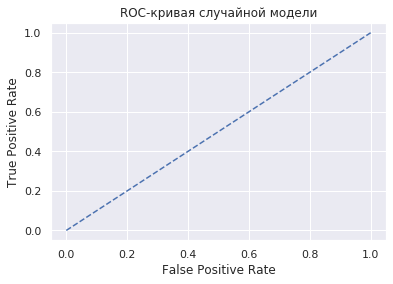

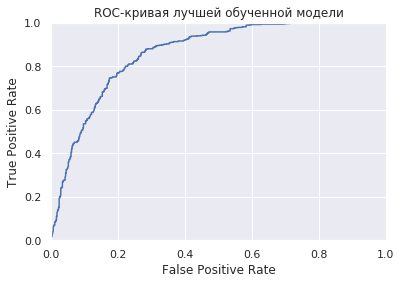

CPU times: user 761 ms, sys: 16.5 ms, total: 778 ms
Wall time: 866 ms


In [154]:
%%time
params = {'max_depth':10, 'min_samples_split':18, 'min_samples_leaf':2, 'random_state':12345, 'class_weight':'balanced'}
model(params, rfc_best, features_test_upsampled, target_test_upsampled)

Сделаем предсказание на тестовой выборке и замерим время для модели CatBoost

AUC-ROC модели:  0.9064093531937735


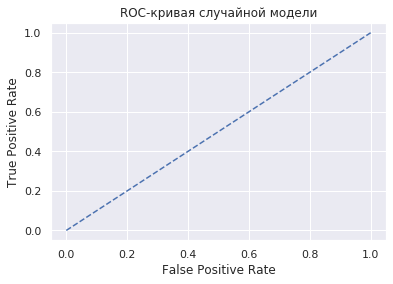

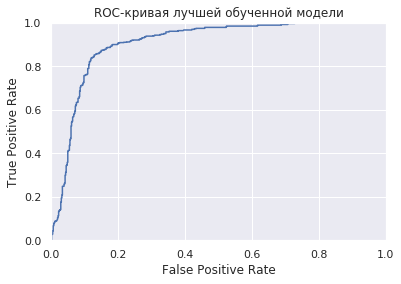

CPU times: user 768 ms, sys: 38 ms, total: 806 ms
Wall time: 799 ms


In [155]:
%%time
params = {'depth':6, 'iterations':600, 'learning_rate':0.5, 'verbose':False, 'random_state':12345}
model(params, cat_best, features_test_upsampled_raw, target_test_upsampled_raw)

In [ ]:
Сделаем предсказание на тестовой выборке и замерим время для модели LightGBM

AUC-ROC модели:  0.9199807338394295


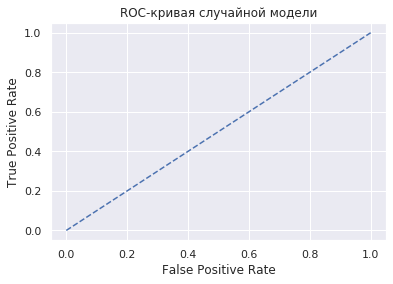

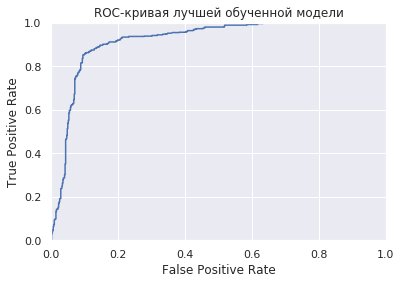

CPU times: user 1.34 s, sys: 24.5 ms, total: 1.37 s
Wall time: 1.32 s


In [156]:
%%time
params = {'learning_rate':0.3, 'max_depth':-1, 'n_estimators':300, 'class_weight':'balanced', 'random_state':12345}
model(params, light_best, features_test_upsampled_raw, target_test_upsampled_raw)

Тестирование показало, что лучший результат по качеству - у модели LightGBM. Также порог преодолела модель CatBoost. Далее сравним полученные показатели в итоговой таблице

<a id='6.2'></a>
### Сравнение моделей и выбор лучших

In [159]:
#Итоговая таблица сравнения моделей 
data = [["34 s", "779 ms", 0.9064],
        ["23min 49s", "1.32 s", 0.9199]]
model = ["CatBoost", "LightGBM"]

pd.DataFrame(data=data, index=model, columns=["Время обучения", "Время предсказания", "AUC-ROC"])

,Время обучения,Время предсказания,AUC-ROC
CatBoost,34 s,779 ms,0.9064
LightGBM,23min 49s,1.32 s,0.9199


Итак, лучший результат по метрике AUC-ROC показала модель LightGBM (0.92) против CatBoost (0.91). Однако и обучается LightGBM в 40 раз дольше, и предсказывает почти в 2 раза дольше. По условиям проекта мы не знаем, насколько важна скорость обучения модели. И так как оба фаворита перешагнули нужный порог (AUC-ROC = 0.88), оставлю их обоих в качестве рекомендованных моделей. В зависимости от точных деталей будущих задач можно будет выбрать или чуть более точный или существенно более быстрый вариант.

<a id='7'></a>
## Общий вывод

В рамках проекта были исследованы данные о клиентах оператора связи и построено неколько прототипов моделей машинного обучения, предсказывающих отток клиентов. По итогам тестирования можно предложить заказчику **две лучшие модели: LightGBM (AUC-ROC = 0.92) и CatBoost (AUC-ROC = 0.91)**. Обе показали качество выше максимальной границы, заказанной в проекте (AUC-ROC >= 0.88), но сильно различаются по скорости обучения, поэтому в зависимости от дальнейших задач заказчик может выбрать более подходящую.  

По условиям проекта оператор планирует на основе предсказаний моделей применять к уходящим клиентам некие меры по удержанию - специальные акции и промокоды. Как показал анализ, предположительно возможны различные причины ухода клиентов - они могут быть в том числе связаны с недовольством сервисами (в разрезе отдельных услуг в некоторых случаях были выявлены бОльшие доли уходов) или ценами (анализ цен показал, что чаще уходят те клиенты, которые платят выше среднего). Поэтому есть смысл помимо признака ухода в будущем попробовать предсказать основную причину, что поможет предложить наиболее удачный промокод/акцию.

**На основании анализа данных можно предложить заказчику приблизительные варианты мер:**  
1. Пользователям DSL. Предложить бесплатный переход на оптоволоконную связь. В зависимости от базовых условий оператора - либо просто бесплатное подключение (в т.ч. установка оборудования), либо 1-2 месяца бесплатно.
2. С помесячным контрактом - годовой/двухгодичный с ощутимой экономией.
3. Пенсионерам - эконом-вариант (например, с небольшим кол-вом трафика)
4. Платящим выше среднего - желателен доп.анализ используемого трафика и телефона (если время тарифицируется), насколько они соответствуют объему оказываемых услуг. Возможно нужно расширить сетку тарифов, добавив более дешевые, чтобы часть пользователей могла сэкономить за счет более точного попадания в их потребности. В таком случае уходящим можно предложить новые тарифы по акции (1-2 месяца бесплатно или со скидкой).